<a href="https://colab.research.google.com/github/mamonalsalihy/Emotion_Detection/blob/main/Models/CNN_github_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
from tqdm.auto import tqdm
import os
import pandas as pd
import csv
import pickle as pkl
import nltk
import matplotlib.pyplot as plt
import seaborn as sea
import re
import os
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import math
from itertools import chain

import gensim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [147]:
# Must upload the dataset splits to google session to read the data.
test_path = './test.csv'
train_path = './train.csv'
valid_path = './valid.csv'

In [ ]:
with open(train_path, "r") as intrain: 
    train = pd.read_csv(intrain)
with open(valid_path, "r") as indev: 
    valid = pd.read_csv(indev)
with open(test_path, "r") as intest: 
    test = pd.read_csv(intest)
train

In [149]:
train_speaker = train.loc[train["speaker_label"] == "speaker"]
train_listener = train.loc[train["speaker_label"] == "listener"]

valid_speaker = valid.loc[valid["speaker_label"] == "speaker"]
valid_listener = valid.loc[valid["speaker_label"] == "listener"]

test_speaker = test.loc[test["speaker_label"] == "speaker"]
test_listener = test.loc[test["speaker_label"] == "listener"]

##Feature Builder Class

In [150]:
class Sequencer(object):
    def __init__(self, tokens, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.pad_index = self.add_token(pad_token)
        self.unk_index = self.add_token(unk_token) 
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)

        for token in tokens:
            self.add_token(token)

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, tokens):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        # print(tokens)
        sequence = [self.bos_index]
        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        sequence.append(self.eos_index)
        # print(sequence)
        return sequence

    def create_padded_tensor(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        # 
        # tensor = torch.tensor(pad_sequences(maxlen=63,sequences=sequences,padding='post',value=0),dtype=torch.long)
        return tensor

class W2VSequencer(object):
    def __init__(self, gensim_w2v):
        self.nlp = spacy.load('en')
        self.w2v = gensim_w2v
        self.w2v.add(['<unk>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])

        self.unk_index = self.w2v.vocab.get('<unk>')
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        sequence = []
        tokens = self.tokenizer(text)
        for token in tokens:

            index = self.w2v.vocab.get(token, self.unk_index).index
            sequence.append(index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Given a list of sequences, pad all to the same length

        max_seq_len = max(len(sequence) for sequence in sequences)
        tensor = torch.full((len(sequences), max_seq_len), 0, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor

# For converting labels into indices
class LabelIndexer(object):
    def __init__(self, labels):
        self.label2idx = {label: i for i, label in enumerate(labels)}
        self.idx2label = {i:label for label, i in self.label2idx.items()}
        self.labels = labels

    def encode(self, y):
        return self.label2idx[y]

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])


## Dataset class

In [151]:
class EmpatheticDataset(Dataset):
    def __init__(self, texts, labels, input_transformer, output_transformer):
        self.texts = texts
        self.labels = labels
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def __getitem__(self, index): # Return a single example
        text = self.texts[index]
        label = self.labels[index]
        x = self.input_transformer(text)
        y = self.output_transformer(label)
        
        return x, y

    def __len__(self):
        return len(self.texts)

## Trainer Class

In [153]:
class MultiClassTrainer(object):
    """
    Trainer for training a multi-class classification model
    """

    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn
        
        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def train(self, loader):
        """
        Run a single epoch of training
        """

        self.model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        for i, batch in tqdm(enumerate(loader)):
            batch_size = batch[0].shape[0]
            self.optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = self.model(batch[0].to(self.device)) # Forward pass, # Wx + b
            #print(logits)
            #print(batch[1].view(-1).to(self.device))
            loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            if self.log_every_n and i % self.log_every_n == 0:
                print("Running loss: ", running_loss)

            running_loss_history.append(running_loss)

            loss.backward() # Perform backprop, which will compute dL/dw

            nn.utils.clip_grad_norm_(self.model.parameters(), 3.0)
            self.optimizer.step() # Update step: w = w - eta * dL / dW

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                logits = self.model(batch[0].to(self.device)) # Run forward pass (except we don't store gradients)
                # logits shape: (batch_size, num_classes)
                
                loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss
                # No backprop is done during validation
                loss_history.append(loss.item())

                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                
                running_loss_history.append(running_loss)

                # Converts the raw outputs into probabilities for each class using softmax
                probs = F.softmax(logits, dim=-1) 
                # probs shape: (batch_size, num_classes)

                predictions = torch.argmax(probs, dim=-1) # Output predictions
                # predictions shape: (batch_size)

                batch_wise_true_labels.append(batch[1].tolist())
                batch_wise_predictions.append(predictions.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions))
        print(confusion_matrix(all_true_labels,all_predictions))
        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

    def run_training(self, train_loader, valid_loader, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        self._print_summary()

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = self.train(train_loader)
            valid_loss_history, valid_running_loss_history = self.evaluate(valid_loader, labels)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_losses))
        valid_epoch_idx = range(len(all_valid_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(x=train_epoch_idx, y=all_train_running_losses)
        sns.lineplot(x=valid_epoch_idx, y=all_valid_running_losses)
        plt.show()

## Data Preparation

In [154]:
def convert_column(dataset, column): 
   texts = [text for text in dataset[column]]
   texts = (*texts,)
   return texts


In [155]:
listener_train = train.loc[train["speaker_label"] == "listener"]
speaker_train = train.loc[train["speaker_label"] == "speaker"]

listener_valid = valid.loc[valid["speaker_label"] == "listener"]
speaker_valid = valid.loc[valid["speaker_label"] == "speaker"]

listener_test = test.loc[train["speaker_label"] == "listener"]
speaker_test = test.loc[train["speaker_label"] == "speaker"]

In [156]:
train = train.drop_duplicates(subset=['clean_prompt'])
valid = valid.drop_duplicates(subset=['clean_prompt'])
#test = test.drop_duplicates(subset=['clean_prompt'])

In [157]:
train_liwc = train[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]
valid_liwc = valid[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]
test_liwc = test[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]


# prompts
train_prompt = convert_column(train,'clean_prompt')
valid_prompt = convert_column(valid,'clean_prompt')
test_prompt = convert_column(test,'clean_prompt')

# utterances
train_utterance = convert_column(train,'clean_utterance')
valid_utterance = convert_column(valid,'clean_utterance')
test_utterance = convert_column(test,'clean_utterance')

# 32 emotions
train_context_labels = convert_column(train,'context')
valid_context_labels = convert_column(valid,'context')
test_context_labels = convert_column(test,'context')

# 3 emotions
train_category_labels = convert_column(train,'emotion_category')
valid_category_labels = convert_column(valid, "emotion_category")
test_category_labels = convert_column(test, "emotion_category")

##CNN

In [158]:
def flatten_list(labels):
  return list(set([tag for tag_seq in labels for tag in tag_seq.split()]))

In [159]:
train_prompt_flattened = flatten_list(train_prompt)
len(train_prompt_flattened)

14885

# Prompts Dataloader w/ 32 labels

In [160]:
label_indexer = LabelIndexer(list(set(train_context_labels+valid_context_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)


def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))

train_sequence_dataset = EmpatheticDataset(train_prompt, train_context_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_prompt,  valid_context_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_prompt, test_context_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=64,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

# Utterance Dataloader w/ 32 labels


In [161]:
label_indexer = LabelIndexer(list(set(train_context_labels+valid_context_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)


def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))


train_sequence_dataset = EmpatheticDataset(train_prompt, train_context_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_utterance,  valid_context_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_utterance, test_context_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=5, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=5,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)



# Prompts Dataloader w/ 3 grouped labels

In [ ]:
label_indexer = LabelIndexer(list(set(train_category_labels+valid_category_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))


train_sequence_dataset = EmpatheticDataset(train_prompt, train_liwc, train_category_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_prompt, valid_liwc,  valid_category_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_prompt, test_liwc, test_category_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=64,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

# Utterance Dataloader w/ 3 grouped labels

In [ ]:
label_indexer = LabelIndexer(list(set(train_category_labels+valid_category_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))

train_sequence_dataset = EmpatheticDataset(train_prompt, train_liwc, train_category_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_utterance, valid_liwc,  valid_category_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_utterance, test_liwc, test_category_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=5, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=5,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

In [165]:

class TextConvolver(nn.Module):
  
    def __init__(self, vocab_size, output_size, kernel_sizes, channel_size=32, dropout=False, dropout_p=0.1, embedding_dim=128,w2v_weights=None):
        super(TextConvolver, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.add_dropout = dropout

        self.dropout = nn.Dropout(dropout_p)

        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, channel_size, kernel_size) for kernel_size in kernel_sizes])

        self.fc = nn.Linear(len(kernel_sizes) * channel_size, output_size)



    def forward(self, x):

        embed = self.embedding(x).transpose(1, 2)

        convs = [F.relu(conv(embed)) for conv in self.convs]

        maxs = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in convs] # Max pool across time

        flattened_maxs = torch.cat(maxs, dim=1)

        logits = self.fc(self.dropout(flattened_maxs))

        return logits

In [166]:
# To print entire confusion matrix
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

TextConvolver(
  (embedding): Embedding(14889, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=32, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


Running loss:  3.9116790294647217
Running loss:  3.7645472288131714
Running loss:  3.739133336327293
Running loss:  3.730199560523033
Running loss:  3.726278407233102
Running loss:  3.7123755308297968
Running loss:  3.6946791602719213
Running loss:  3.6884312166108026
Running loss:  3.680620082994787
Running loss:  3.665627655775651
Running loss:  3.6486783308141373
Running loss:  3.638628538165774
Running loss:  3.6250422391735144
Running loss:  3.617750391815649
Running loss:  3.606244553982373
Running loss:  3.5951518604629924
Running loss:  3.5818469524383554
Running loss:  3.567683280900468
Running loss:  3.5565275071741462
Running loss:  3.5485605448484425
Running loss:  3.540915224811819
Running loss:  3.531664340001233
Running loss:  3.52449005788511
Running loss:  3.5134681689328158
Running loss:  3.5025708005448015
Running loss:  3.491602746267167
Running loss:  3.4845845535511275
Running loss:  3.477660920690087
Running loss:  3.4696282393543423
Running loss:  3.460903327758


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.20      0.25      0.22        85
           1       0.37      0.10      0.16       101
           2       0.16      0.54      0.25        92
           3       0.07      0.03      0.04        75
           4       0.06      0.03      0.04        69
           5       0.17      0.37      0.24        75
           6       0.26      0.30      0.28        81
           7       0.25      0.19      0.21        75
           8       0.40      0.16      0.23        50
           9       0.36      0.16      0.22        88
          10       0.17      0.15      0.16        81
          11       0.38      0.08      0.13       102
          12       0.22      0.12      0.15        94
          13       0.27      0.29      0.28        85
          14       0.19      0.27      0.22        90
          15       0.11      0.12      0.12        81
          16       0.39      0.50      0.44  

Running loss:  2.9534549713134766
Running loss:  2.825231591860453
Running loss:  2.8496224229986016
Running loss:  2.842408165335655
Running loss:  2.849384864171346
Running loss:  2.8377853173476004
Running loss:  2.8516506533468924
Running loss:  2.867558459440867
Running loss:  2.845848763861307
Running loss:  2.841527669326119
Running loss:  2.839005175758811
Running loss:  2.8409810066223145
Running loss:  2.8346029930427425
Running loss:  2.8356560360301626
Running loss:  2.830991825587313
Running loss:  2.8299890662494462
Running loss:  2.8253670680670093
Running loss:  2.823129385016686
Running loss:  2.8197357811770605
Running loss:  2.8155553961793585
Running loss:  2.8149044442884996
Running loss:  2.8190500871190487
Running loss:  2.8164321538564323
Running loss:  2.8188636487927927
Running loss:  2.815896668709999
Running loss:  2.8150009919726653
Running loss:  2.807149535827054
Running loss:  2.80475709192893
Running loss:  2.7983512624781177
Running loss:  2.7939065319


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29        85
           1       0.25      0.27      0.26       101
           2       0.39      0.47      0.43        92
           3       0.21      0.25      0.23        75
           4       0.31      0.06      0.10        69
           5       0.25      0.29      0.27        75
           6       0.29      0.32      0.30        81
           7       0.22      0.13      0.17        75
           8       0.38      0.20      0.26        50
           9       0.27      0.30      0.28        88
          10       0.35      0.25      0.29        81
          11       0.21      0.29      0.24       102
          12       0.36      0.26      0.30        94
          13       0.27      0.33      0.29        85
          14       0.32      0.13      0.19        90
          15       0.17      0.25      0.20        81
          16       0.39      0.55      0.46  

Running loss:  2.317371129989624
Running loss:  2.451168338457743
Running loss:  2.478951389139348
Running loss:  2.4947655051946636
Running loss:  2.504431588309151
Running loss:  2.5440937097256
Running loss:  2.543939890400056
Running loss:  2.53392008278105
Running loss:  2.526375799644285
Running loss:  2.532379767169124
Running loss:  2.54668776661742
Running loss:  2.53412903206689
Running loss:  2.52430094265547
Running loss:  2.5240256388982143
Running loss:  2.526701023880865
Running loss:  2.5348295914499386
Running loss:  2.5388450445952238
Running loss:  2.5440839307252747
Running loss:  2.5495038399329553
Running loss:  2.552398592233658
Running loss:  2.5568798863061586
Running loss:  2.553995838705099
Running loss:  2.555633682388444
Running loss:  2.554099570060599
Running loss:  2.5495109794553654
Running loss:  2.5531170689870444
Running loss:  2.5569538451333087
Running loss:  2.5562920377534986
Running loss:  2.5541534626737556
Running loss:  2.5545998583101244
Run


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.29      0.34      0.32        85
           1       0.20      0.35      0.26       101
           2       0.49      0.42      0.45        92
           3       0.40      0.13      0.20        75
           4       0.35      0.16      0.22        69
           5       0.26      0.20      0.23        75
           6       0.26      0.17      0.21        81
           7       0.22      0.16      0.19        75
           8       0.33      0.26      0.29        50
           9       0.37      0.32      0.34        88
          10       0.32      0.28      0.30        81
          11       0.35      0.18      0.24       102
          12       0.25      0.53      0.34        94
          13       0.34      0.25      0.29        85
          14       0.49      0.19      0.27        90
          15       0.19      0.21      0.20        81
          16       0.34      0.73      0.46  

Running loss:  2.5517871379852295
Running loss:  2.432645877202352
Running loss:  2.4194625290957363
Running loss:  2.421155542135238
Running loss:  2.395752180190313
Running loss:  2.3956044820638804
Running loss:  2.394089321936331
Running loss:  2.381280773215824
Running loss:  2.40313301435331
Running loss:  2.4048057898231177
Running loss:  2.4122588353998524
Running loss:  2.4154482185840607
Running loss:  2.4075079237828487
Running loss:  2.4193490743637085
Running loss:  2.4157153552686665
Running loss:  2.4206079244613647
Running loss:  2.4206350879904663
Running loss:  2.426495213841283
Running loss:  2.434110610039679
Running loss:  2.4302636831998816
Running loss:  2.431869178715318
Running loss:  2.436881254304129
Running loss:  2.4373480156735248
Running loss:  2.438810101870832
Running loss:  2.4387321058383646
Running loss:  2.443930796214511
Running loss:  2.4464781084133462
Running loss:  2.4431530991021315
Running loss:  2.442023607010536
Running loss:  2.43762459656


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.44      0.27      0.34        85
           1       0.32      0.29      0.30       101
           2       0.44      0.47      0.46        92
           3       0.33      0.20      0.25        75
           4       0.55      0.09      0.15        69
           5       0.20      0.29      0.24        75
           6       0.30      0.42      0.35        81
           7       0.28      0.17      0.21        75
           8       0.53      0.18      0.27        50
           9       0.27      0.35      0.31        88
          10       0.21      0.51      0.30        81
          11       0.30      0.30      0.30       102
          12       0.41      0.32      0.36        94
          13       0.30      0.31      0.30        85
          14       0.24      0.23      0.24        90
          15       0.18      0.32      0.23        81
          16       0.66      0.57      0.61  

Running loss:  2.4171860218048096
Running loss:  2.3624667723973594
Running loss:  2.3393114263361148
Running loss:  2.3186148554086685
Running loss:  2.304260390145438
Running loss:  2.3186607452539296
Running loss:  2.3130459862370643
Running loss:  2.3108872506353593
Running loss:  2.3179287096349204
Running loss:  2.3205619065657905
Running loss:  2.317872973049388
Running loss:  2.3305171472685675
Running loss:  2.324059857696783
Running loss:  2.324460553400444
Running loss:  2.3210370775679463
Running loss:  2.318655842228939
Running loss:  2.326772733970924
Running loss:  2.3195756479751224
Running loss:  2.324884262713757
Running loss:  2.32914728919665
Running loss:  2.32704501576943
Running loss:  2.324700643431466
Running loss:  2.3233767414952187
Running loss:  2.3215871001112056
Running loss:  2.3240100588680304
Running loss:  2.3221967239228514
Running loss:  2.3219707212375327
Running loss:  2.3190670004662355
Running loss:  2.318240366083511
Running loss:  2.3199520625


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.30      0.38      0.34        85
           1       0.32      0.16      0.21       101
           2       0.56      0.43      0.49        92
           3       0.32      0.45      0.38        75
           4       0.50      0.07      0.13        69
           5       0.23      0.25      0.24        75
           6       0.33      0.35      0.34        81
           7       0.30      0.15      0.20        75
           8       0.56      0.20      0.29        50
           9       0.38      0.39      0.38        88
          10       0.34      0.41      0.37        81
          11       0.27      0.28      0.28       102
          12       0.35      0.38      0.36        94
          13       0.22      0.33      0.26        85
          14       0.23      0.29      0.25        90
          15       0.34      0.31      0.32        81
          16       0.66      0.63      0.64  

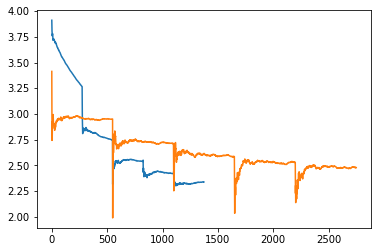

In [167]:
vocab_size = len(sequencer_.idx2word)

output_size = len(label_indexer.idx2label)
loss_fn = nn.CrossEntropyLoss()
cnn = TextConvolver(vocab_size, output_size, [3, 4, 5], channel_size=100, dropout_p=0.5)
cnn_optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn_trainer = MultiClassTrainer(cnn, cnn_optimizer, loss_fn, device=device, log_every_n=5)
cnn_trainer.run_training(train_sequence_loader, valid_sequence_loader, label_indexer.labels, n_epochs=5)

In [ ]:
cnn_trainer.run_training(train_sequence_loader, test_sequence_loader, label_indexer.labels, n_epochs=1)

In [169]:
torch.cuda.empty_cache()